In [32]:
import numpy as np
import pandas as pd

# Check current directory
import os
print(os.getcwd())

/Users/lesarmstrong/Documents/GitHub/6.C51/sustainable_systems/Final_Project


In [33]:
# Load DAM and RTM .csv
DAM = pd.read_csv('Data_Clean/DAM.csv')
RTM = pd.read_csv('Data_Clean/RTM.csv')

# From RTM take Delivert Date Delivery Hour Delivery Interval and Settlement Point Price columns
RTM = RTM[['Delivery Date', 'Delivery Hour', 'Delivery Interval', 'Settlement Point Price']]

# From DAM take Delivery Date Hour Ending and Settlement Point Price columns
DAM = DAM[['Delivery Date', 'Hour Ending', 'Settlement Point Price']]

from datetime import timedelta
# Function to adjust '24:00' to '00:00' and calculate the interval time
def create_time_intervals_corrected(hour, interval):
    if hour == "24:00":
        hour = "00:00"
    hour_datetime = pd.to_datetime(hour, format='%H:%M')
    interval_time = hour_datetime + timedelta(minutes=(interval - 5) * 15)
    return interval_time.strftime('%H:%M')

# Expand the DAM dataset to account for 15-minute intervals
dam_intervals = pd.DataFrame({"Delivery Interval": range(1, 5)})
DAM['key'] = 1
dam_intervals['key'] = 1
DAM = pd.merge(DAM, dam_intervals, on='key').drop('key', axis=1)

# Create the 'Interval Time' column for DAM
DAM['Interval Time'] = DAM.apply(lambda x: create_time_intervals_corrected(x['Hour Ending'], x['Delivery Interval']), axis=1)

# Prepare the 'Hour Ending' column for RTM to format hours correctly and create 'Interval Time'
RTM['Hour Ending'] = RTM['Delivery Hour'].apply(lambda x: f"{x:02d}:00")
RTM['Interval Time'] = RTM.apply(lambda x: create_time_intervals_corrected(x['Hour Ending'], x['Delivery Interval']), axis=1)

# For both, split up the Delivert Date into 3 columns representing day, month, and year
DAM['Delivery Date'] = pd.to_datetime(DAM['Delivery Date'])
DAM['Year'] = DAM['Delivery Date'].dt.year
DAM['Month'] = DAM['Delivery Date'].dt.month
DAM['Day'] = DAM['Delivery Date'].dt.day

RTM['Delivery Date'] = pd.to_datetime(RTM['Delivery Date'])
RTM['Year'] = RTM['Delivery Date'].dt.year
RTM['Month'] = RTM['Delivery Date'].dt.month
RTM['Day'] = RTM['Delivery Date'].dt.day




In [6]:
RTM

# Print the 10 highest Settlement Point Prices
#print(RTM['Settlement Point Price'].nlargest(10))

,Delivery Date,Delivery Hour,Delivery Interval,Settlement Point Price,Hour Ending,Interval Time,Year,Month,Day
0,2012-01-01,1,1,12.58,01:00,00:00,2012,1,1
1,2012-01-01,1,2,8.83,01:00,00:15,2012,1,1
2,2012-01-01,1,3,13.44,01:00,00:30,2012,1,1
3,2012-01-01,1,4,12.95,01:00,00:45,2012,1,1
4,2012-01-01,2,1,13.22,02:00,01:00,2012,1,1
...,...,...,...,...,...,...,...,...,...
35627,2023-01-31,23,4,39.87,23:00,22:45,2023,1,31
35628,2023-01-31,24,1,41.06,24:00,23:00,2023,1,31
35629,2023-01-31,24,2,41.78,24:00,23:15,2023,1,31
35630,2023-01-31,24,3,38.39,24:00,23:30,2023,1,31


In [11]:
# Combine DAM and RTM on Interval Time.
df = pd.merge(DAM, RTM, on=['Delivery Date', 'Interval Time'], suffixes=('_DAM', '_RTM'))
#  Only keep Interval Time Delivery Date and Settlement Point Price, day, month, year
df = df[['Delivery Hour', 'Settlement Point Price_DAM', 'Settlement Point Price_RTM', 'Day_DAM', 'Month_DAM', 'Year_DAM', 'Day_RTM', 'Month_RTM', 'Year_RTM']]
df

,Delivery Hour,Settlement Point Price_DAM,Settlement Point Price_RTM,Day_DAM,Month_DAM,Year_DAM,Day_RTM,Month_RTM,Year_RTM
0,1,18.19,12.58,1,1,2012,1,1,2012
1,1,18.19,8.83,1,1,2012,1,1,2012
2,1,18.19,13.44,1,1,2012,1,1,2012
3,1,18.19,12.95,1,1,2012,1,1,2012
4,2,16.99,13.22,1,1,2012,1,1,2012
...,...,...,...,...,...,...,...,...,...
35627,23,53.18,39.87,31,1,2023,31,1,2023
35628,24,46.95,41.06,31,1,2023,31,1,2023
35629,24,46.95,41.78,31,1,2023,31,1,2023
35630,24,46.95,38.39,31,1,2023,31,1,2023


In [30]:
# Set up BIDIRECTIONAL LSTM NETWORK ARCHITECTURE
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.regularizers import l2


import matplotlib.pyplot as plt

In [15]:
# Define function to compare and plot model predictions from actual values
# Allow to zoom into a certain interval on the x axis

def plot_comparison(predictions, actual, startx=None, endx=None, starty=None, endy=None):
    """
    Plot the predicted vs actual values with an optional x-axis limit.

    Parameters:
        predictions (array-like): The predicted values.
        actual (array-like): The actual values.
        start (int, optional): Start index for x-axis limit.
        end (int, optional): End index for x-axis limit.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predicted', marker='o')  # Added markers for better visibility
    plt.plot(actual, label='Actual', marker='x')  # Added markers for better visibility
    plt.legend()
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.title('Comparison of Predictions and Actual Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

    
    # Plot the differences between the actual value and the predicted value
    plt.figure(figsize=(12, 6))
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.plot(predictions - actual, label='Difference')
    plt.legend()
    
    plt.show()
    

In [16]:
def relative_mae(y_true, y_pred):
    """
    Calculates the Relative Mean Absolute Error (Relative MAE). an arguably better metric is the relative MAE (rMAE). 
    Similar to MASE, rMAE normalizes the MAE by the MAE of a naive forecast. 
    However, instead of considering the in-sample dataset, the naive forecast is built based on the out-of-sample dataset.
    
    Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.
        
    Returns:
        float: The Relative Mean Absolute Error.
    """
    mae = np.mean(np.abs(y_pred - y_true))  # Calculate the Mean Absolute Error
    mean_actual = np.mean(np.abs(y_true))  # Calculate the mean of absolute values of actual data
    
    return mae / mean_actual


In [ ]:
def direction_accuracy():
    """
    For applications like virtual bidding, when it is difficult to predict the magnitude of the price difference,
    it is still valuable to predict the sign of the price difference where
    n = total number of correctly detected direction (or sign) of price difference,
    N = total number of price differences. 
    """
    
    
    

In [17]:
# Set up the data
# For X use DAM settlement point price, day, month, and year
# For y use RTM settlement point price
from sklearn.preprocessing import OneHotEncoder

def encode_data(df=df):
        
    enc = OneHotEncoder(handle_unknown='ignore')

    # Separate the features to be one-hot encoded
    X_categorical = df[['Delivery Hour', 'Day_DAM', 'Month_DAM', 'Year_DAM']]
    X_categorical = enc.fit_transform(X_categorical).toarray()

    # Keep the 'Settlement Point Price_DAM' feature as it is
    X_continuous = df[['Settlement Point Price_DAM']].values
    #'Settlement Point Price_DAM', 'Settlement Point Price_RTM',
    # Concatenate the one-hot encoded features with the continuous feature
    X = np.concatenate([X_continuous, X_categorical], axis=1)

    y = df['Settlement Point Price_RTM'].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the data
    # Normalize the data
    scaler_X = MinMaxScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    scaler_y = MinMaxScaler()
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test = scaler_y.transform(y_test.reshape(-1, 1))

    # Reshape the data for the LSTM model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return(X_train, X_test, y_train, y_test, scaler_X, scaler_y)

X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()

  1/223 [..............................] - ETA: 17s

223/223 [==============================] - 2s 9ms/step


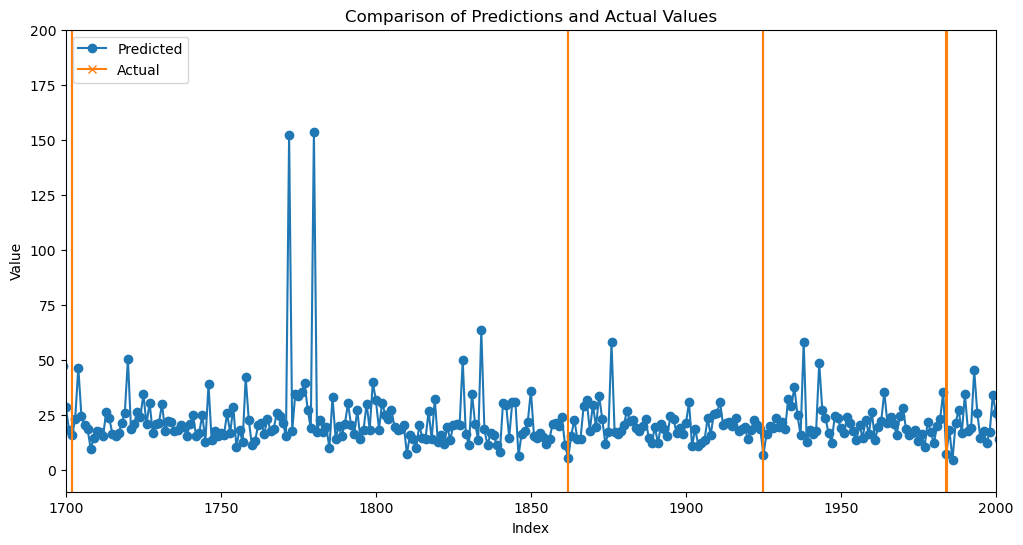

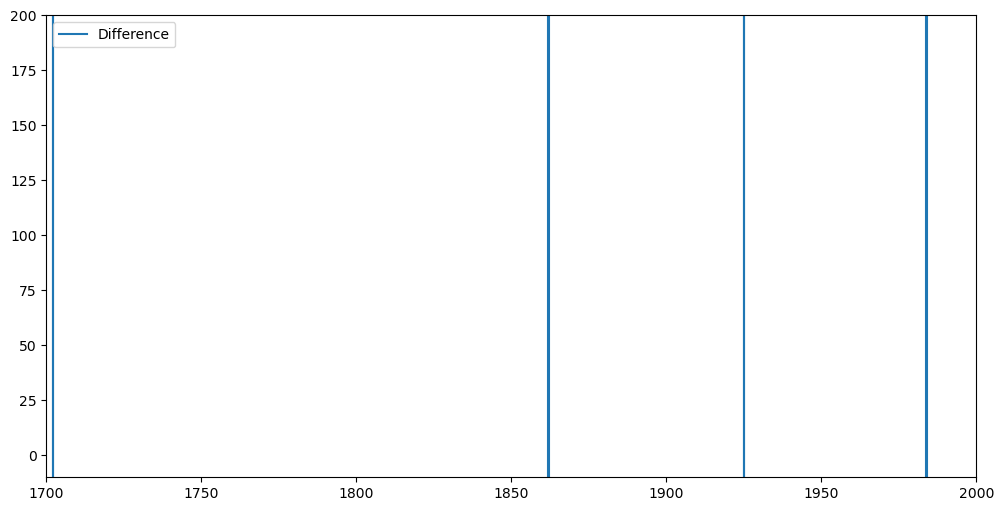

Mean Absolute Error: 3304915166779.976
Mean Squared Error: 1.0786660770768434e+26
Root Mean Squared Error: 10385885022841.547
R-squared: -0.11210806973324083


/Users/lesarmstrong/miniconda3/envs/1.c51-env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [64]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()

# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# Plot the predictions
plot_comparison(y_pred, y_test, startx=1700, endx=2000, starty=-10, endy=200)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

In [ ]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()

# Model 1
model_1 = Sequential()
model_1.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu'), input_shape=(X_train.shape[1], 1)))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')

# Train model
model_1.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
y_pred_1 = model_1.predict(X_test)
y_pred_1 = scaler.inverse_transform(y_pred_1)
y_test = scaler.inverse_transform(y_test)

# Show accuracy
mse = mean_squared_error(y_test, y_pred_1)
print(f'Mean Squared Error: {mse}')
print(f'Accuracy: {100 - mse}%')


Epoch 1/100
28505/28505 - 137s - loss: 2.1840e-04 - 137s/epoch - 5ms/step
Epoch 2/100


In [ ]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()

model_2 = Sequential()
model_2.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01)), input_shape=(X_train.shape[1], 1)))
model_2.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01))))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mse')

# Train model
model_2.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)
# Make predictions
y_pred_2 = model_2.predict(X_test)
y_pred_2 = scaler.inverse_transform(y_pred_2)
y_test = scaler.inverse_transform(y_test)

# Show accuracy
mse = mean_squared_error(y_test, y_pred_2)
print(f'Mean Squared Error: {mse}')
print(f'Accuracy: {100 - mse}%')

In [34]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()

model_3 = Sequential()
model_3.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01)), input_shape=(X_train.shape[1], 1)))
model_3.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01))))
model_3.add(Bidirectional(LSTM(10, return_sequences=False, activation='relu', kernel_regularizer=l2(0.01))))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mse')
# Train model
#model_3.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)
model_3.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)


Epoch 1/20
891/891 - 109s - loss: 0.2576 - 109s/epoch - 122ms/step
Epoch 2/20
891/891 - 101s - loss: 2.2181e-04 - 101s/epoch - 114ms/step
Epoch 3/20
891/891 - 100s - loss: 2.2131e-04 - 100s/epoch - 112ms/step
Epoch 4/20
891/891 - 99s - loss: 2.2162e-04 - 99s/epoch - 111ms/step
Epoch 5/20
891/891 - 98s - loss: 2.2124e-04 - 98s/epoch - 110ms/step
Epoch 6/20
891/891 - 100s - loss: 2.2162e-04 - 100s/epoch - 112ms/step
Epoch 7/20
891/891 - 107s - loss: 2.2170e-04 - 107s/epoch - 120ms/step
Epoch 8/20
891/891 - 106s - loss: 2.2134e-04 - 106s/epoch - 119ms/step
Epoch 9/20
891/891 - 105s - loss: 2.2124e-04 - 105s/epoch - 118ms/step
Epoch 10/20
891/891 - 96s - loss: 2.2128e-04 - 96s/epoch - 108ms/step
Epoch 11/20
891/891 - 101s - loss: 2.2140e-04 - 101s/epoch - 113ms/step
Epoch 12/20
891/891 - 106s - loss: 2.2125e-04 - 106s/epoch - 119ms/step
Epoch 13/20
891/891 - 100s - loss: 2.2142e-04 - 100s/epoch - 112ms/step
Epoch 14/20
891/891 - 99s - loss: 2.2138e-04 - 99s/epoch - 111ms/step
Epoch 15/20
8

In [ ]:
# Make predictions
y_pred_3 = model_3.predict(X_test)
y_pred_3 = scaler_y.inverse_transform(y_pred_3)
y_test = scaler_y.inverse_transform(y_test)

# Show accuracy
mse = mean_squared_error(y_test, y_pred_3)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
print(f'Accuracy: {100 - mse}%')
plot_comparison(y_pred_3, y_test, startx=1700, endx=2000, starty=-10, endy=200)


In [ ]:
# Save model_3
model_3.save('model_3.h5')

# Load model_3
from keras.models import load_model
model_3 = load_model('model_3.h5')


/Users/lesarmstrong/miniconda3/envs/1.c51-env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


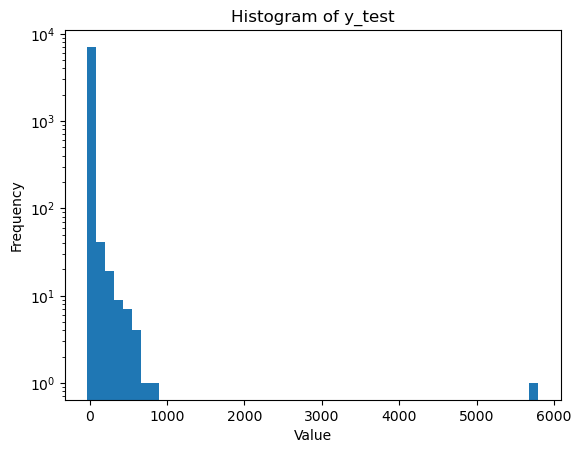

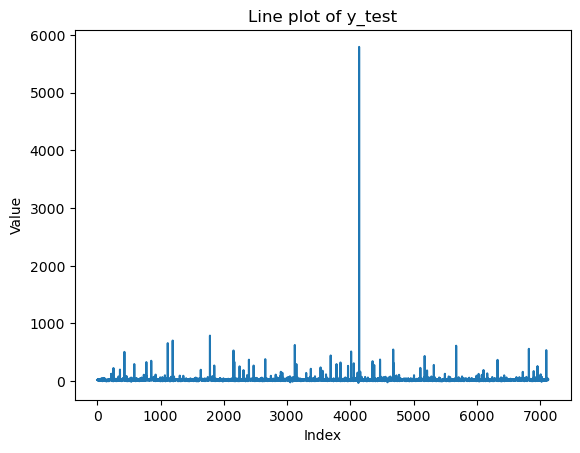

In [98]:
# Plot y_test
plt.hist(y_test, bins=50, log=True)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Line plot y_test
plt.plot(y_test)
plt.title('Line plot of y_test')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()



In [93]:
y_test.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

# Seq2Seq

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout

### Model 1

In [ ]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()


input_seq_length = X_train.shape[1]  # This is the length of the input sequences
num_encoder_tokens = X_train.shape[2]  # This is the number of features/tokens in the input

output_seq_length = y_train.shape[1]  # This is the length of the output sequences
num_decoder_tokens = y_train.shape[2]  # This is the number of features/tokens in the output

# Define the input shape for the encoder
encoder_inputs = Input(shape=(input_seq_length, num_encoder_tokens))
encoder_lstm = LSTM(50, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the input shape for the decoder
decoder_inputs = Input(shape=(output_seq_length, num_decoder_tokens))
decoder_lstm = LSTM(20, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add a dropout layer after the LSTM layers
decoder_outputs = Dropout(0.2)(decoder_outputs)

# Define the dense output laayer with dropout
decoder_dense = Dense(42, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model_1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_1.summary() 

### Model 2

In [ ]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()


input_seq_length = X_train.shape[1]  # This is the length of the input sequences
num_encoder_tokens = X_train.shape[2]  # This is the number of features/tokens in the input

output_seq_length = y_train.shape[1]  # This is the length of the output sequences
num_decoder_tokens = y_train.shape[2]  # This is the number of features/tokens in the output

# Define the input shape for the encoder
encoder_inputs = Input(shape=(input_seq_length, num_encoder_tokens))
encoder_lstm1 = LSTM(96, return_sequences=True, return_state=True, dropout=0.2)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

# Define the second LSTM layer with dropout
encoder_lstm2 = LSTM(64, return_state=True, dropout=0.2)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
encoder_states = [state_h2, state_c2]

# Define the decoder input and LSTM layer with dropout using the last encoder states as initial state
decoder_inputs = Input(shape=(None, output_features))
decoder_lstm = LSTM(20, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add a dropout layer after the LSTM layers
decoder_outputs = Dropout(0.2)(decoder_outputs)

# Define the dense output layer with dropout
decoder_dense = Dense(42, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model_2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_2.summary()

### Model 3

In [ ]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = encode_data()


input_seq_length = X_train.shape[1]  # This is the length of the input sequences
num_encoder_tokens = X_train.shape[2]  # This is the number of features/tokens in the input

output_seq_length = y_train.shape[1]  # This is the length of the output sequences
num_decoder_tokens = y_train.shape[2]  # This is the number of features/tokens in the output

# Define the input shape for the encoder
encoder_inputs = Input(shape=(input_seq_length, num_encoder_tokens))

encoder_lstm1 = LSTM(128, return_sequences=True, return_state=True, dropout=0.2)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

# Define the second LSTM layer with dropout
encoder_lstm2 = LSTM(64, return_sequences=True, return_state=True, dropout=0.2)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

# Define the third LSTM layer with dropout, note return_sequences is False because it's the last encoder layer
encoder_lstm3 = LSTM(32, return_state=True, dropout=0.2)
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)
encoder_states = [state_h3, state_c3]

# Define the decoder input and LSTM layer with dropout using the last encoder states as initial state
decoder_inputs = Input(shape=(None, num_decoder_tokens))  # Replace None with your actual sequence length for the decoder
decoder_lstm = LSTM(20, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add a dropout layer after the LSTM layers
decoder_outputs = Dropout(0.2)(decoder_outputs)

# Define the dense output layer
decoder_dense = Dense(42, activation='softmax')  # The number 42 corresponds to the number of classes
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Seq2Seq model that will turn `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model_3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_3.summary()



In [ ]:
# Use model to predict values
y_pred = model_3.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# Show accuracy
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
print(f'Accuracy: {100 - mse}%')

# Plot the predictions
plot_comparison(y_pred, y_test, startx=1700, endx=2000, starty=-10, endy=200)
